<a href="https://colab.research.google.com/github/Saul-Rier/hub/blob/master/%E9%A3%8E%E6%A0%BC%EF%BC%88GPU%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U mxnet-cu101==1.7.0

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x5617d9700000 @  0x7f669f3f5615 0x5617a04cbcdc 0x5617a05ab52a 0x5617a04ceafd 0x5617a05bffed 0x5617a0542988 0x5617a053d4ae 0x5617a04d03ea 0x5617a05427f0 0x5617a053d4ae 0x5617a04d03ea 0x5617a053f32a 0x5617a05c0e36 0x5617a053e853 0x5617a05c0e36 0x5617a053e853 0x5617a05c0e36 0x5617a053e853 0x5617a05c0e36 0x5617a053e853 0x5617a04d030a 0x5617a053e60e 0x5617a053d7ad 0x5617a04d03ea 0x5617a053e3b5 0x5617a04d030a 0x5617a053e3b5 0x5617a053d4ae 0x5617a04d03ea 0x5617a053f32a 0x5617a053d4ae
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!pip install d2lzh

  Created wheel for d2lzh: filename=d2lzh-1.0.0-cp37-none-any.whl size=10054 sha256=e36e6c81d943def2c7987d967146ae0207c045a059877c7df6cdc157a728ed62
  Stored in directory: /root/.cache/pip/wheels/13/1c/a3/b00e9d91505a5ab745de5ebd4a141f2dd7802f39e4940ca775
Successfully built d2lzh


In [76]:
import d2lzh as d2l
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time
from mxnet import np, npx

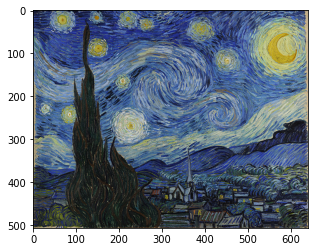

In [77]:
content_img = image.imread('7.jpg')
d2l.plt.imshow(content_img.asnumpy());

style_img = image.imread('2.jpg')
d2l.plt.imshow(style_img.asnumpy());


In [78]:
# 图片RGB三通道的均值和标准差
'''这里我不是很懂，不同的图片这个值应该是不一样的，这个应该根据传入的图片分别
   计算各自的均值和标准差吧，原代码直接用给出的这个值标准化内容图片和风格图片，
   不过所有图片好像都可以用这个。。。而且效果还不错。。。在此提出疑问QAQ。
'''
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)# clip用来确保像素值在0到1之间，因为神经网络可能会迭代一些负数出来哦


In [79]:
pretraind_VGG = model_zoo.vision.vgg19(pretrained=True, root='这里是你的模型参数缓存路径，不设置的话为默认值')
pretraind_VGG.features #查看一下网络的构成（不考虑output层））

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Activation(relu)
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Activation(relu)
  (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Activation(relu)
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Activation(relu)
  (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Activation(relu)
  (16): Conv2D(256 -> 256

In [80]:
style_layers, content_layers = [0, 5, 10, 12, 19, 28], [29]

In [81]:
net = nn.HybridSequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretraind_VGG.features[i])

In [82]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [83]:
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [84]:
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()

In [85]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2]*X.shape[3]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / X.size

def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()

In [86]:
def tv_loss(Y_hat):
    return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                  (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())

In [87]:
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [88]:
class GeneratedImage(nn.HybridBlock):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()

In [89]:
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam', {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [90]:
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [92]:
# 尺寸自己设定
content_weight, style_weight, tv_weight, ctx, image_shape= 1, 3e3, 30, d2l.try_gpu(), (150,100)
net.collect_params().reset_ctx(ctx)
ctx
net.hybridize()
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.05, 800, 200)

epoch  50, content loss 4.36, style loss 12.90, TV loss 10.93, 0.02 sec
epoch 100, content loss 3.83, style loss 6.72, TV loss 9.78, 0.02 sec
epoch 150, content loss 3.59, style loss 4.75, TV loss 8.93, 0.02 sec
epoch 200, content loss 3.44, style loss 3.92, TV loss 8.34, 0.02 sec
change lr to 5.0e-03
epoch 250, content loss 3.43, style loss 3.84, TV loss 8.25, 0.02 sec
epoch 300, content loss 3.42, style loss 3.78, TV loss 8.19, 0.02 sec
epoch 350, content loss 3.41, style loss 3.72, TV loss 8.13, 0.02 sec
epoch 400, content loss 3.40, style loss 3.67, TV loss 8.07, 0.02 sec
change lr to 5.0e-04
epoch 450, content loss 3.40, style loss 3.66, TV loss 8.06, 0.02 sec
epoch 500, content loss 3.39, style loss 3.65, TV loss 8.05, 0.02 sec
epoch 550, content loss 3.39, style loss 3.65, TV loss 8.05, 0.02 sec
epoch 600, content loss 3.39, style loss 3.64, TV loss 8.04, 0.02 sec
change lr to 5.0e-05
epoch 650, content loss 3.39, style loss 3.64, TV loss 8.04, 0.02 sec
epoch 700, content loss 3

In [93]:
# 尺寸自己设定
image_shape = (450,300)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.02, 400, 200)

epoch  50, content loss 2.27, style loss 3.86, TV loss 7.71, 0.04 sec
epoch 100, content loss 1.76, style loss 2.27, TV loss 7.15, 0.04 sec
epoch 150, content loss 1.54, style loss 1.72, TV loss 6.69, 0.04 sec
epoch 200, content loss 1.42, style loss 1.44, TV loss 6.29, 0.04 sec
change lr to 2.0e-03
epoch 250, content loss 1.41, style loss 1.42, TV loss 6.24, 0.04 sec
epoch 300, content loss 1.40, style loss 1.40, TV loss 6.20, 0.04 sec
epoch 350, content loss 1.38, style loss 1.38, TV loss 6.15, 0.04 sec


In [94]:
# 尺寸自己设定
image_shape = (600,400)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 200, 100)

epoch  50, content loss 1.27, style loss 1.91, TV loss 5.49, 0.07 sec
epoch 100, content loss 1.05, style loss 1.33, TV loss 5.18, 0.07 sec
change lr to 1.0e-03
epoch 150, content loss 1.03, style loss 1.29, TV loss 5.14, 0.07 sec


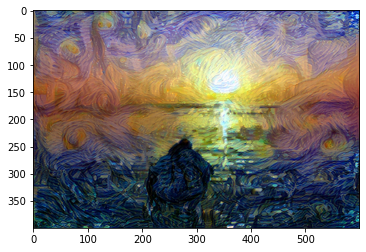

In [95]:
d2l.plt.imshow(postprocess(output).asnumpy())
#d2l.plt.imsave('', postprocess(output).asnumpy())